# Automated generation of DisCoCirc from text

In [1]:
from discocirc.pipeline.text_to_circuit import text_to_circuit

c:\Users\Razin Shaikh\OneDrive\Documents\CQC\DisCoCirc\text_to_discocirc\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


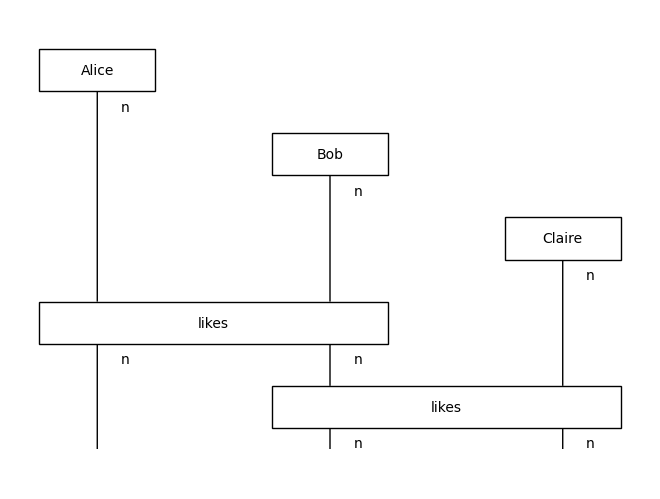

In [65]:
text_to_circuit("Alice likes Bob. Bob likes Claire.").draw()

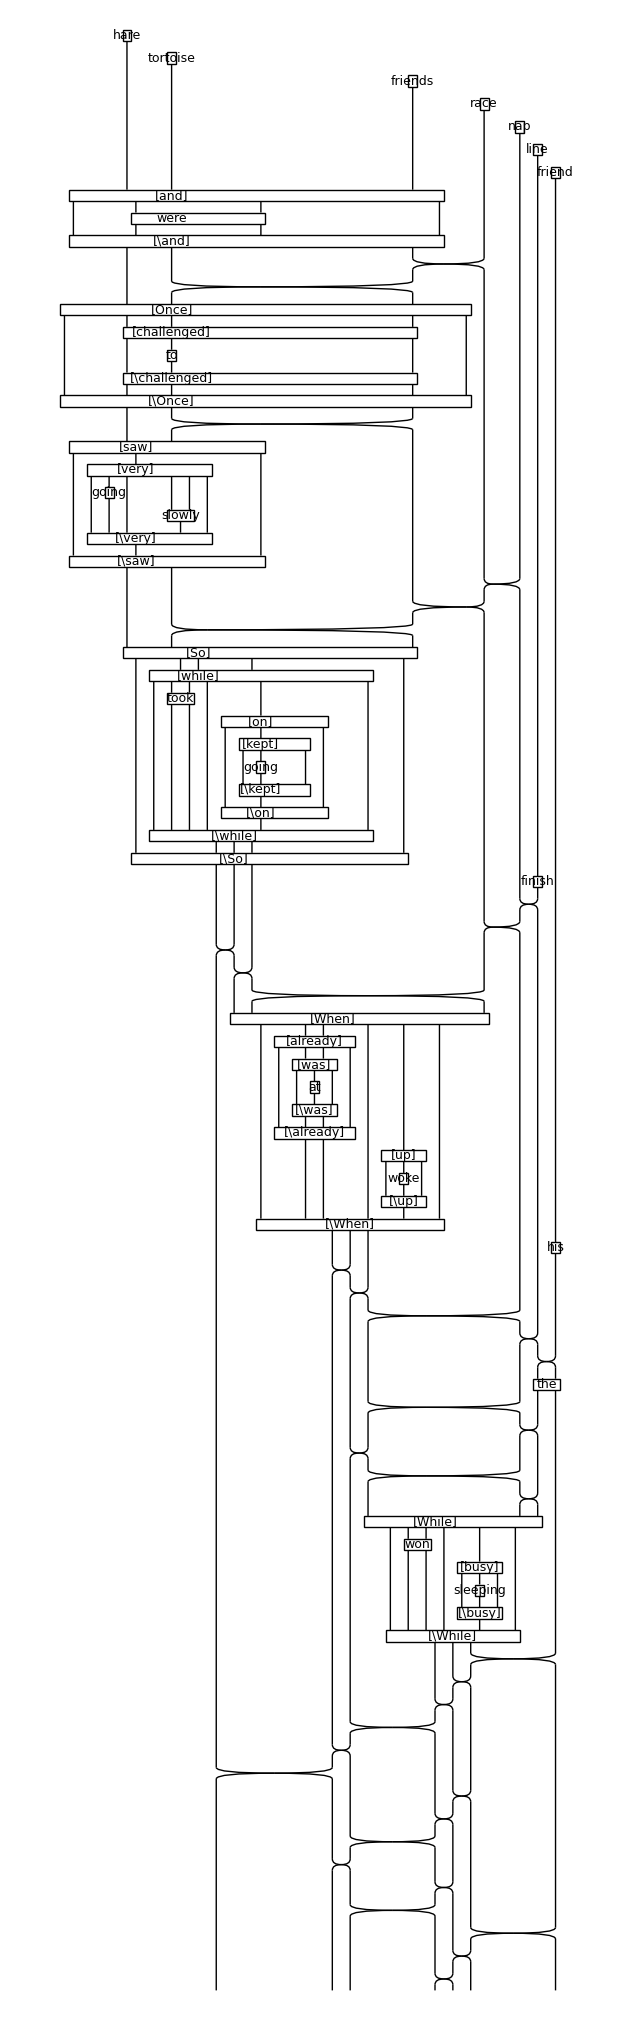

In [66]:
text = "A hare and a tortoise were friends. Once the hare challenged the tortoise to a race. \
The hare saw that the tortoise was going very slowly. So the hare took a nap while the tortoise kept on going. \
When the hare woke up, the tortoise was already at the finish line. \
While the hare was busy sleeping, his friend the tortoise won the race."

fig_config = {"figsize": (6,20), "fontsize": 9, "draw_type_labels": False, "margins": (0.1, 0.01)}

text_to_circuit(text).draw(**fig_config)

# Example: Alice loves Bob

### Parse the sentence

In [67]:
from lambeq import BobcatParser
parser = BobcatParser()

In [98]:
ccg_tree = parser.sentence2tree("Alice loves Bob")
print(ccg_tree.deriv())

Alice   loves   Bob
═════  ═══════  ═══
  n    (s\n)/n   n 
──<U>           <U>
  n              n 
       ───────────>
           s\n     
──────────────────<
         s         


### Convert the parse tree to a lambda expression

In [69]:
from discocirc.expr.ccg_to_expr import ccg_to_expr

In [99]:
expr1 = ccg_to_expr(ccg_tree)
expr1

    loves      Bob       
═════════════  ═══       
(n → (n → s))   n   Alice
──────────────────  ═════
     (n → s)          n  
─────────────────────────
            s            

In [71]:
from discocirc.expr.expr_to_diag import draw_expr

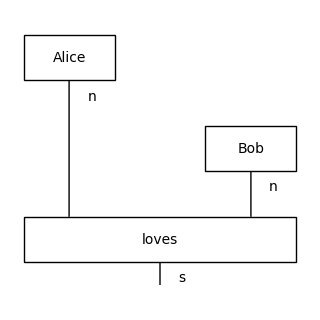

In [72]:
draw_expr(expr1, figsize=(3,3))

### S-type expansion

In [73]:
from discocirc.expr.s_type_expand import s_type_expand

In [74]:
expr2 = s_type_expand(expr1)
expr2

      loves        Bob       
═════════════════  ═══       
(n → (n → n @ n))   n   Alice
──────────────────────  ═════
     (n → n @ n)          n  
─────────────────────────────
            n @ n            

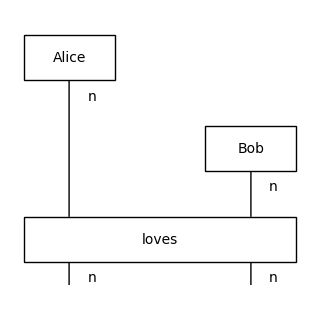

In [75]:
draw_expr(expr2, figsize=(3,3))

# Example 2: "Alice quickly ran"
### higher-order boxes

In [76]:
ccg_tree = parser.sentence2tree("Alice quickly ran")
print(ccg_tree.deriv())

Alice    quickly    ran
═════  ═══════════  ═══
  n    (s\n)/(s\n)  s\n
──<U>  ───────────────>
  n          s\n       
──────────────────────<
           s           


In [77]:
expr1 = ccg_to_expr(ccg_tree)
expr1

      quickly          ran         
═══════════════════  ═══════       
((n → s) → (n → s))  (n → s)  Alice
────────────────────────────  ═════
          (n → s)               n  
───────────────────────────────────
                 s                 

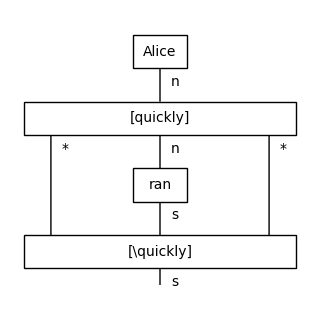

In [78]:
draw_expr(expr1, figsize=(3,3))

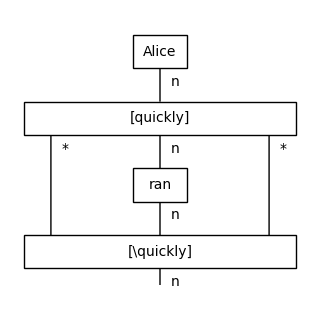

In [79]:
expr2 = s_type_expand(expr1)
draw_expr(expr2, figsize=(3,3))

# Example 3: "I really like Bob"
### pulling out of frames

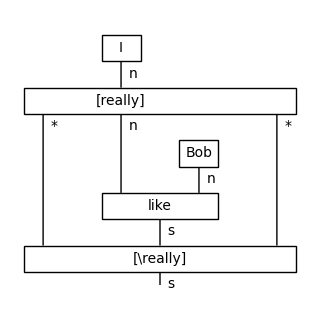

In [80]:
ccg_tree = parser.sentence2tree("I really like Bob")
expr1 = ccg_to_expr(ccg_tree)
draw_expr(expr1, figsize=(3,3))

In [81]:
expr1

                         like       Bob   
                     ═════════════  ═══   
      really         (n → (n → s))   n    
═══════════════════  ──────────────────   
((n → s) → (n → s))       (n → s)        I
───────────────────────────────────────  ═
                (n → s)                  n
──────────────────────────────────────────
                    s                     

The state "Bob" is trapped inside the frame. We need to 'pull it out' to the top, so that the "Bob" wire can compose at the top with other circuits

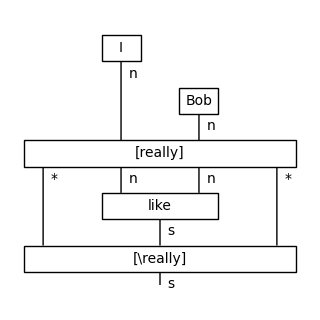

In [82]:
from discocirc.expr.pull_out import pull_out
expr2 = pull_out(expr1)
draw_expr(expr2, figsize=(3,3))

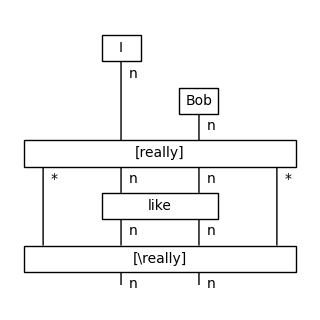

In [83]:
expr3 = s_type_expand(expr2)
draw_expr(expr3, figsize=(3,3))

# Example 4: "Bob who loves Alice runs"
### N-type expansion

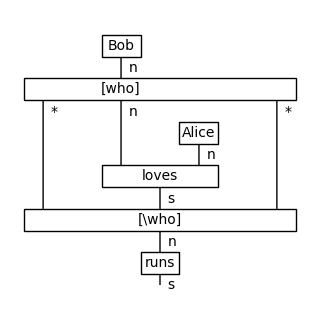

In [84]:
ccg_tree = parser.sentence2tree("Bob who loves Alice runs")
expr1 = ccg_to_expr(ccg_tree)
draw_expr(expr1, figsize=(3,3))

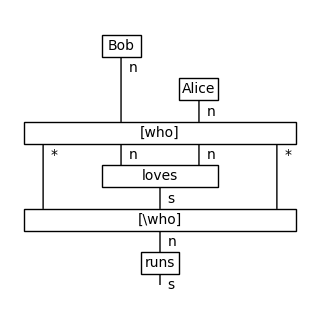

In [85]:
expr2 = pull_out(expr1)
draw_expr(expr2, figsize=(3,3))

This is an interesting situation. "Bob who loves Alice" is treated as a single noun phrase which has the head "Bob". Diagrammatically, this corresponds to a single n-type wire.

Below, we show what happens if we just naively apply s-type expansion to the diagram.

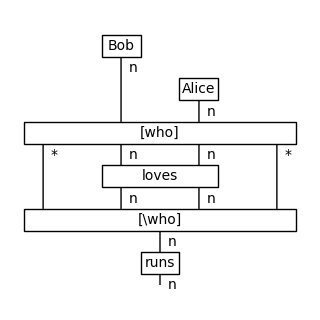

In [21]:
expr3 = s_type_expand(expr2)
draw_expr(expr3, figsize=(3,3))

This is no good. We have two nouns at the top but only one at the bottom (which can be interpreted as representing "Bob"). Ideally we would also like to be able to access "Alice" as an outgoing wire. So, we need to expand the n-type wire of "Bob who loves Alice" into two n-type wires -- one representing "Bob" and one representing "Alice". 

Note also that as per the sentence "Bob who loves Alice runs", only "Bob" is doing the running, not "Alice". So after we expand the n-type wire into two, we need to ensure only the one corresponding to head grammatical head "Bob" is fed into "runs".

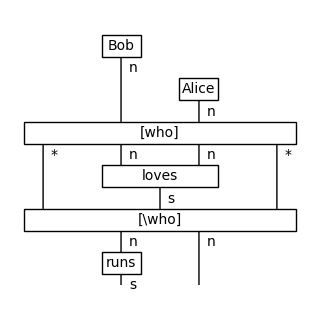

In [86]:
from discocirc.expr.n_type_expand import n_type_expand
expr4 = n_type_expand(expr2)
draw_expr(expr4, figsize=(3,3))

This is much better. After performing this n-type expansion, we can do the s-type expansion as usual

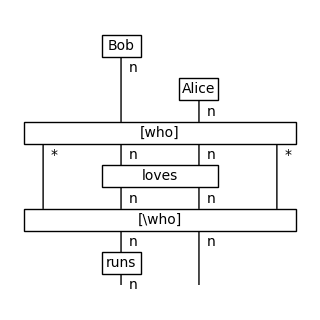

In [87]:
expr5 = s_type_expand(expr4)
draw_expr(expr5, figsize=(3,3))

# Example 5: Alice and Bob quickly drink tea
### Coordination-of-nouns expansion

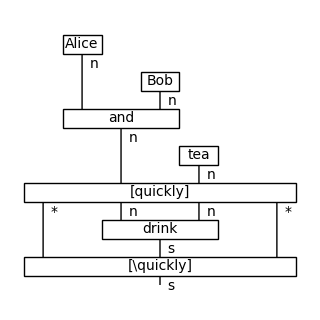

In [88]:
ccg_tree = parser.sentence2tree("Alice and Bob quickly drink tea")
expr1 = ccg_to_expr(ccg_tree)
expr2 = pull_out(expr1)
draw_expr(expr2, figsize=(3,3))

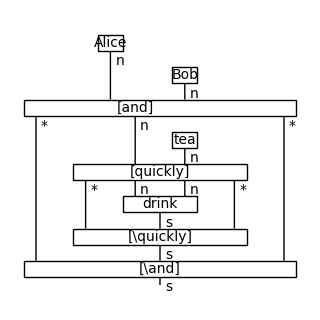

In [89]:
from discocirc.expr.coordination_expand import coordination_expand
expr3 = coordination_expand(expr2)
draw_expr(expr3, figsize=(3,3))

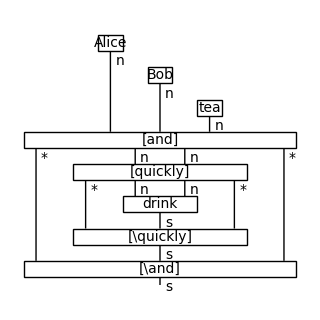

In [90]:
expr4 = pull_out(expr3)
draw_expr(expr4, figsize=(3,3))

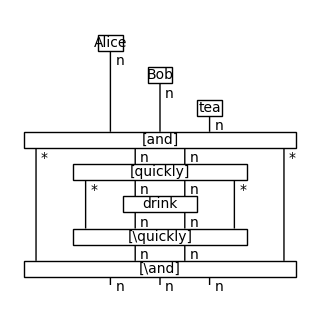

In [27]:
expr5 = n_type_expand(expr4)
expr6 = s_type_expand(expr5)
draw_expr(expr6, figsize=(3,3))

# Example 6: Bob drinks his tea
### Possessive pronouns coreference

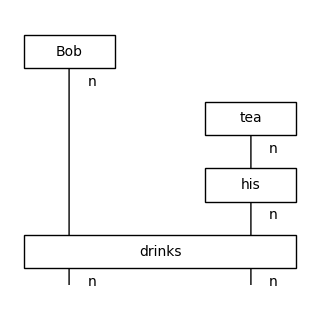

In [91]:
sentence = "Bob drinks his tea"
ccg_tree = parser.sentence2tree(sentence)
expr1 = ccg_to_expr(ccg_tree)
expr2 = pull_out(expr1)
expr3 = coordination_expand(expr2)
expr4 = pull_out(expr3)
expr5 = n_type_expand(expr4)
expr6 = s_type_expand(expr5)
draw_expr(expr6, figsize=(3,3))

In [92]:
import spacy
spacy_model = spacy.load('en_core_web_trf')
spacy_model.add_pipe('coreferee')
spacy_sentence = spacy_model(sentence)

In [93]:
spacy_sentence._.coref_chains

[0: [0], [2]]

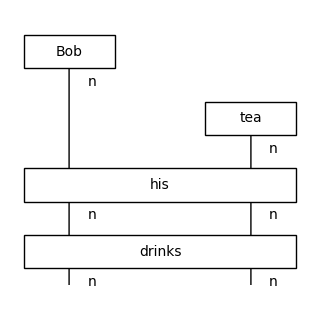

In [35]:
from discocirc.expr.expr_possessive_pronouns import expand_coref
expr7 = expand_coref(expr6, spacy_sentence)
draw_expr(expr7, figsize=(3,3))

# Semantic rewrites

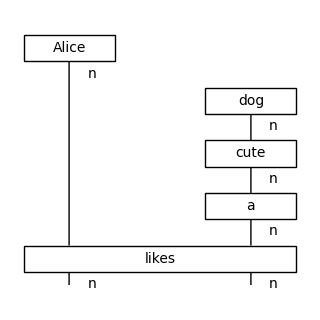

In [ ]:
sentence = "Alice likes a cute dog"
ccg_tree = parser.sentence2tree(sentence)
expr1 = ccg_to_expr(ccg_tree)
expr2 = pull_out(expr1)
expr3 = coordination_expand(expr2)
expr4 = pull_out(expr3)
expr5 = n_type_expand(expr4)
expr6 = s_type_expand(expr5)
draw_expr(expr6, figsize=(3,3))

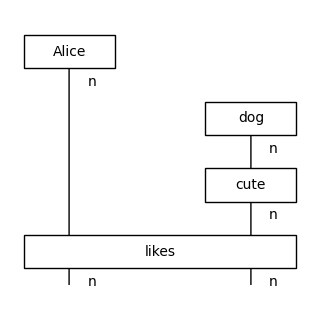

In [54]:
from discocirc.expr.expr_to_diag import expr_to_diag
diag = expr_to_diag(expr6)

from discocirc.semantics.rewrite import rewrite
rewrite(diag, rules=['remove_articles']).draw(figsize=(3,3))

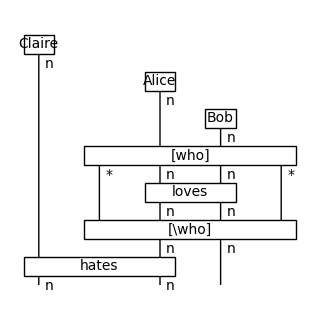

In [56]:
sentence = "Claire hates Alice who loves Bob"
ccg_tree = parser.sentence2tree(sentence)
expr1 = ccg_to_expr(ccg_tree)
expr2 = pull_out(expr1)
expr3 = coordination_expand(expr2)
expr4 = pull_out(expr3)
expr5 = n_type_expand(expr4)
expr6 = s_type_expand(expr5)
draw_expr(expr6, figsize=(3,3))

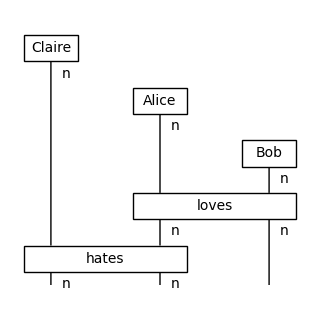

In [57]:
from discocirc.expr.expr_to_diag import expr_to_diag
diag = expr_to_diag(expr6)

from discocirc.semantics.rewrite import rewrite
rewrite(diag, rules=['remove_relative_pronouns']).draw(figsize=(3,3))

# Multiple sentences

In [59]:
from discocirc.pipeline.text_to_circuit import sentence_list_to_circuit

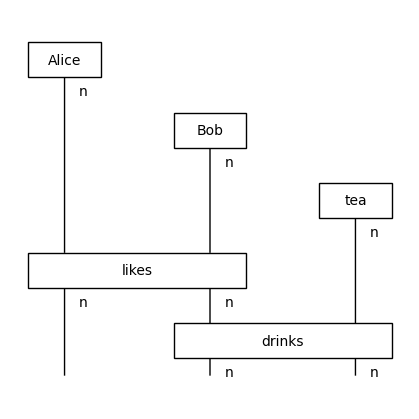

In [60]:
sentence_list_to_circuit(["Alice likes Bob", "Bob drinks tea"]).draw(figsize=(4,4))

# Converting to a quantum circuit

In [61]:
from lambeq.ansatz.circuit import Sim14Ansatz
from discopy import monoidal

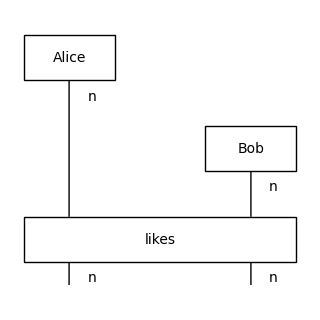

In [63]:
diag = text_to_circuit("Alice likes Bob")
diag.draw(figsize=(3,3))

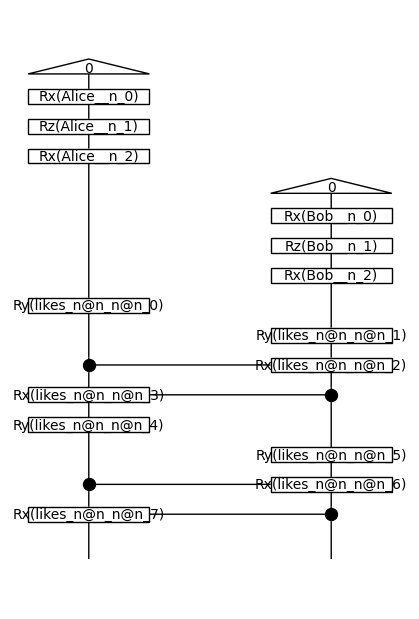

In [64]:
Sim14Ansatz({monoidal.Ty('n'): 1,}, n_layers=1)(diag).draw(figsize=(4, 6))